# Data Scientist - TOTVS Labs Challenge 2018

Using the given dataset of transactions (notas fiscais eletrônicas) from a restaurant:
https://github.com/TOTVS/MDMStatic/blob/master/code-challenge/TOTVS%20Labs%20-%20AI%20Challenge%20-%20Dataset.zip?raw=true 

1. Parse and extract the data.
2. Identify a pattern on any set of fields that can help predict how much a customer will spend.
3. Calculate a sales forecast for the next week.

We recommend that you spend not more than 5 hours on the challenge.


Evaluation criteria

1. Ability to read/parse a dataset from a file.
2. Understanding of common business data.
3. Basic knowledge of artificial intelligence.
4. Ability to build a model to identify correlations and patterns between fields.
5. Code design
6. Ability to write clear documentation
7. BONUS: Ability to build a forecast model.


Submission

1. A link to the github repository.
2. Briefly explain the models that you used/built

Let´s begin parsing and extracting the data.

In [2]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
with open('sample.txt', 'r') as json_file:
    json_data = json.load(json_file)

In [4]:
len(json_data)

1635

A first look in the data

In [5]:
print(json_data[0])

{'complemento': {'valorTotal': 24.9}, 'dets': [{'nItem': '1', 'prod': {'indTot': '1', 'qCom': 1.0, 'uCom': 'UN', 'vProd': 3.5, 'vUnCom': 3.5, 'xProd': 'AGUA'}}, {'nItem': '2', 'prod': {'indTot': '1', 'qCom': 0.312, 'uCom': 'KG', 'vProd': 21.4, 'vUnCom': 68.6, 'xProd': 'BUFFET'}}], 'emit': {'cnpj': '01.234.567/0001-89', 'enderEmit': {'fone': '1-650-933-4902', 'xBairro': '', 'xLgr': '650 Castro St. unit 210', 'xMun': 'Mountain View', 'xPais': 'United States', 'uf': 'CA'}, 'xFant': 'TOTVS Labs'}, 'ide': {'dhEmi': {'$date': '2016-01-05T12:01:54.000Z'}, 'natOp': 'VENDA'}, 'infAdic': {'infCpl': 'Mesa 2'}, 'total': {'icmsTot': {'vDesc': 0.0, 'vFrete': 0.0, 'vOutro': 0.0, 'vProd': 24.9, 'vSeg': 0.0, 'vTotTrib': 2.53, 'vbc': 0.0, 'vbcst': 0.0, 'vcofins': 0.0, 'vicms': 0.0, 'vicmsDeson': 0.0, 'vii': 0.0, 'vipi': 0.0, 'vnf': 24.9, 'vpis': 0.0, 'vst': 0.0}}, 'versaoDocumento': 1.0}


As we have a nested json, we will need to parse it. First, the header of the document:

In [6]:
li_vlnf = []
li_cnpj = []
li_mun = []
li_dhemi = []
for vlnf in json_data:
    li_vlnf.extend([vlnf['complemento']['valorTotal']])
    li_cnpj.extend([vlnf['emit']['cnpj']])
    li_mun.extend([vlnf['emit']['enderEmit']['xMun']])
    li_dhemi.extend([vlnf['ide']['dhEmi']['$date']])
    
list_labels = ['ValorNota', 'Cnpj', 'Municipio', 'DtHoraEmi']
list_cols = [li_vlnf, li_cnpj, li_mun, li_dhemi]
zipped = list(zip(list_labels, list_cols))

di_nf = dict(zipped)
df_nf = pd.DataFrame(di_nf)
df_nf['NumNota'] = np.arange(1, len(df_nf) + 1)
df_nf.head()

,Cnpj,DtHoraEmi,Municipio,ValorNota,NumNota
0,01.234.567/0001-89,2016-01-05T12:01:54.000Z,Mountain View,24.90,1
1,01.234.567/0001-89,2016-01-05T12:03:52.000Z,Mountain View,92.53,2
2,01.234.567/0001-89,2016-01-05T12:16:40.000Z,Mountain View,57.86,3
3,01.234.567/0001-89,2016-01-05T12:17:50.000Z,Mountain View,34.97,4
4,01.234.567/0001-89,2016-01-05T12:18:35.000Z,Mountain View,46.23,5


In [7]:
df_nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 5 columns):
Cnpj         1635 non-null object
DtHoraEmi    1635 non-null object
Municipio    1635 non-null object
ValorNota    1635 non-null float64
NumNota      1635 non-null int32
dtypes: float64(1), int32(1), object(3)
memory usage: 57.6+ KB


Let's correct the field type

In [8]:
df_nf['DtHoraEmi'] = pd.to_datetime(df_nf['DtHoraEmi'])
df_nf.head()

,Cnpj,DtHoraEmi,Municipio,ValorNota,NumNota
0,01.234.567/0001-89,2016-01-05 12:01:54,Mountain View,24.90,1
1,01.234.567/0001-89,2016-01-05 12:03:52,Mountain View,92.53,2
2,01.234.567/0001-89,2016-01-05 12:16:40,Mountain View,57.86,3
3,01.234.567/0001-89,2016-01-05 12:17:50,Mountain View,34.97,4
4,01.234.567/0001-89,2016-01-05 12:18:35,Mountain View,46.23,5


In [9]:
df_nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 5 columns):
Cnpj         1635 non-null object
DtHoraEmi    1635 non-null datetime64[ns]
Municipio    1635 non-null object
ValorNota    1635 non-null float64
NumNota      1635 non-null int32
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 57.6+ KB


Let´s check some features in our data if they make sense. Maybe we'll drop them:

In [10]:
df_nf.Cnpj.value_counts()

01.234.567/0001-89    1635
Name: Cnpj, dtype: int64

In [11]:
df_nf = df_nf.drop('Cnpj', axis=1)

In [12]:
df_nf.Municipio.value_counts()

Mountain View    1635
Name: Municipio, dtype: int64

In [13]:
df_nf = df_nf.drop('Municipio', axis=1)

In [14]:
df_nf.index = df_nf['DtHoraEmi']
df_nf.head()

,DtHoraEmi,ValorNota,NumNota
DtHoraEmi,,,
2016-01-05 12:01:54,2016-01-05 12:01:54,24.90,1
2016-01-05 12:03:52,2016-01-05 12:03:52,92.53,2
2016-01-05 12:16:40,2016-01-05 12:16:40,57.86,3
2016-01-05 12:17:50,2016-01-05 12:17:50,34.97,4
2016-01-05 12:18:35,2016-01-05 12:18:35,46.23,5


Let's check for missing data:

In [15]:
df_nf.isnull().all().all()

False

Good, we don't have any missing values.

Now let's do some **Exploratory Data Analysis (EDA)**

In [16]:
df_nf['ValorNota'].describe()

count    1635.000000
mean       55.504171
std        39.217462
min         9.740000
25%        30.985000
50%        43.260000
75%        69.230000
max       608.910000
Name: ValorNota, dtype: float64

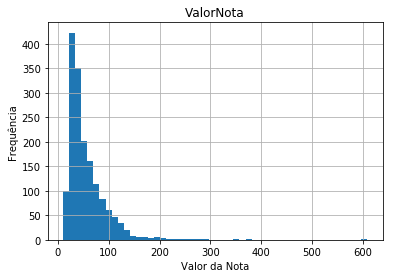

In [17]:
pd.DataFrame.hist(df_nf[['ValorNota']], bins=50)
plt.xlabel('Valor da Nota')
plt.ylabel('Frequência')
plt.show()

Now we can get a sense of the overall pattern of the data from the histogram's shape and spread:

### SHAPE

The distribution is **unimodal** — it has one mode (roughly at **30**) around which the observations are concentrated and  **skewed right** (the term 'skew' refers to the direction of the longer tail).

### SPREAD

As a measure of spread (variability) of the distribuition we have:
#### Range (Max - min) = 608.91 - 9.74 = ?

In [18]:
range = df_nf['ValorNota'].max() - df_nf['ValorNota'].min()
print('Range = ' + str(range))

Range = 599.17


#### Inter-quartile range (IQR)
The IQR measures the variability of a distribution by giving us the range covered by the MIDDLE 50% of the data, where **IQR = Q3 - Q1** *(3rd quartile - 1st quartile)*

In [19]:
Q1, Q3 = np.percentile(df_nf['ValorNota'], [25, 75])
IQR = Q3 - Q1
print('IQR = ' + str(IQR))

IQR = 38.24499999999999


Let's plot a visual representation of the five number summary and IQR:

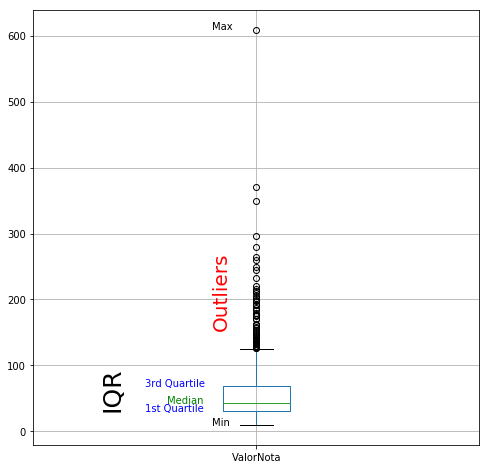

In [20]:
df_nf.boxplot(column="ValorNota",
               return_type='axes',
               figsize=(8,8))
plt.text(x=0.75, y=df_nf['ValorNota'].quantile(0.75), s="3rd Quartile", color='blue')
plt.text(x=0.80, y=df_nf['ValorNota'].quantile(0.50), s="Median", color='green')
plt.text(x=0.75, y=df_nf['ValorNota'].quantile(0.25), s="1st Quartile", color='blue')
plt.text(x=0.90, y=df_nf['ValorNota'].min(), s="Min")
plt.text(x=0.90, y=df_nf['ValorNota'].max(), s="Max")
plt.text(x=0.65, y=df_nf['ValorNota'].quantile(0.75), s="IQR", rotation=90, size=25)
plt.text(x=0.90, y=250, s="Outliers", rotation=90, size=20, color='red')
plt.show()

Outliers are observations that fall outside the overall pattern. An observation is considered a suspected outlier if it is:
    **below Q1 - 1.5(IQR)** or
    **above Q3 + 1.5(IQR)** 
And, as we can see, we have several outliers on this data set.

**Warning**: Even though it is an extreme value, if an outlier can be understood to have been produced by essentially the same sort of physical process as the rest of the data, and if such extreme values are expected to eventually occur again, then such an outlier indicates something important and interesting about the process you're investigating, and it should be kept in the data.

On the other hand, an outlier might indicate a mistake in the data (like a typo, or a measuring error), in which case **it should be corrected if possible or else removed from the data** before calculating summary statistics or making inferences from the data (and the reason for the mistake should be investigated).

![Limpando dados](http://nerdnumbers.com/wp-content/uploads/2014/07/data_cleaning.jpg)

** 2-Identify a pattern on any set of fields that can help predict how much a customer will spend. **

Now let's try to find some relationships between the value of the transactions and the others variables that we have on the data set.

With the variable "DtHoraEmi" we can extract "day" (since the data are within the same month and year), "week day" and "hour", but, in this last case, as we don't see significant difference between hours, individually, we are going to "break" this information in 2 categorical values: lunch-time (from 11h to 15h) and dinner-time (from 18h to 23h).

In [21]:
import datetime
df_nf['DofWeek'] = df_nf['DtHoraEmi'].dt.dayofweek #The day of the week with Monday=0, Sunday=6
df_nf['Day'] = df_nf['DtHoraEmi'].dt.day
df_nf['Hour'] = df_nf['DtHoraEmi'].apply(lambda x: 'lunch-time' if x.hour <= 15 else 'dinner-time')
df_nf['Hour'] = df_nf['Hour'].astype('category')
df_nf.head()

,DtHoraEmi,ValorNota,NumNota,DofWeek,Day,Hour
DtHoraEmi,,,,,,
2016-01-05 12:01:54,2016-01-05 12:01:54,24.90,1,1,5,lunch-time
2016-01-05 12:03:52,2016-01-05 12:03:52,92.53,2,1,5,lunch-time
2016-01-05 12:16:40,2016-01-05 12:16:40,57.86,3,1,5,lunch-time
2016-01-05 12:17:50,2016-01-05 12:17:50,34.97,4,1,5,lunch-time
2016-01-05 12:18:35,2016-01-05 12:18:35,46.23,5,1,5,lunch-time


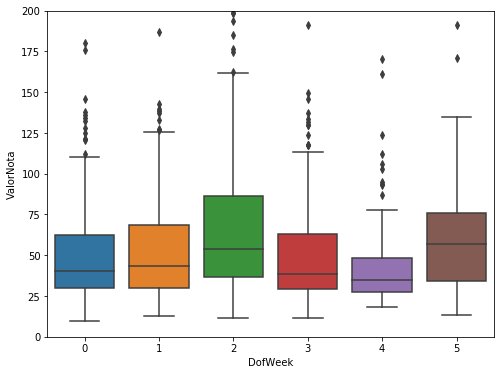

In [22]:
var = 'DofWeek'
data = pd.concat([df_nf['ValorNota'], df_nf[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="ValorNota", data=data)
fig.axis(ymin=0, ymax=200)
plt.show()
#The day of the week with Monday=0, Sunday=6

We can see bigger values on Wednesdays and Saturdays!

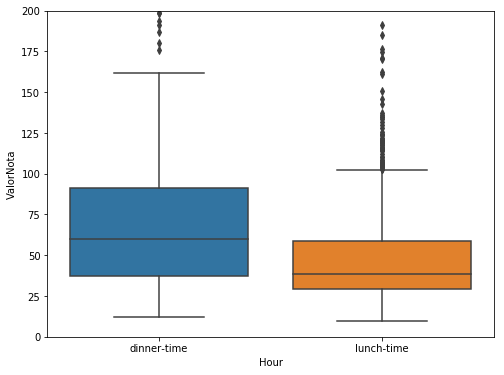

In [23]:
var = 'Hour'
data = pd.concat([df_nf['ValorNota'], df_nf[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="ValorNota", data=data)
fig.axis(ymin=0, ymax=200)
plt.show()

Apparently, people are hungrier on "dinner-time"!

Let´s try to see both features at the same time:

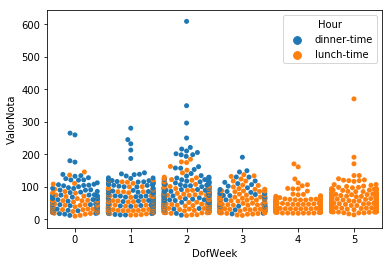

In [25]:
sns.swarmplot(x="DofWeek", y="ValorNota", data=df_nf, hue='Hour')
plt.show()

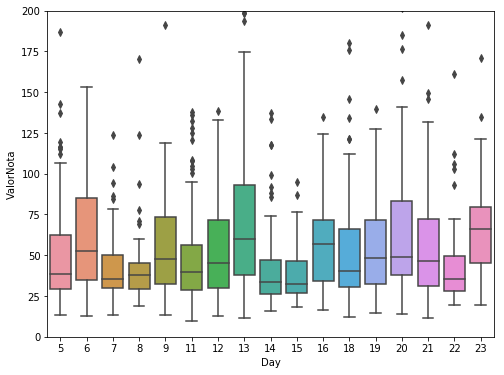

In [26]:
var = 'Day'
data = pd.concat([df_nf['ValorNota'], df_nf[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="ValorNota", data=data)
fig.axis(ymin=0, ymax=200)
plt.show()

Dealing with categorical features

● Scikit-learn will not accept categorical features by default

● Need to encode categorical features numerically

● Convert to ‘dummy variables’

In [27]:
dummies = pd.get_dummies(df_nf['Hour'])
df_nf = pd.concat([df_nf, dummies], axis=1)
df_nf.head()

,DtHoraEmi,ValorNota,NumNota,DofWeek,Day,Hour,dinner-time,lunch-time
DtHoraEmi,,,,,,,,
2016-01-05 12:01:54,2016-01-05 12:01:54,24.90,1,1,5,lunch-time,0,1
2016-01-05 12:03:52,2016-01-05 12:03:52,92.53,2,1,5,lunch-time,0,1
2016-01-05 12:16:40,2016-01-05 12:16:40,57.86,3,1,5,lunch-time,0,1
2016-01-05 12:17:50,2016-01-05 12:17:50,34.97,4,1,5,lunch-time,0,1
2016-01-05 12:18:35,2016-01-05 12:18:35,46.23,5,1,5,lunch-time,0,1


In [28]:
df_nf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1635 entries, 2016-01-05 12:01:54 to 2016-01-23 14:56:35
Data columns (total 8 columns):
DtHoraEmi      1635 non-null datetime64[ns]
ValorNota      1635 non-null float64
NumNota        1635 non-null int32
DofWeek        1635 non-null int64
Day            1635 non-null int64
Hour           1635 non-null category
dinner-time    1635 non-null uint8
lunch-time     1635 non-null uint8
dtypes: category(1), datetime64[ns](1), float64(1), int32(1), int64(2), uint8(2)
memory usage: 155.1 KB


In [29]:
dummies = pd.get_dummies(df_nf['DofWeek'], prefix='DoW')
df_nf = pd.concat([df_nf, dummies], axis=1)
df_nf.head()

,DtHoraEmi,ValorNota,NumNota,DofWeek,Day,Hour,dinner-time,lunch-time,DoW_0,DoW_1,DoW_2,DoW_3,DoW_4,DoW_5
DtHoraEmi,,,,,,,,,,,,,,
2016-01-05 12:01:54,2016-01-05 12:01:54,24.90,1,1,5,lunch-time,0,1,0,1,0,0,0,0
2016-01-05 12:03:52,2016-01-05 12:03:52,92.53,2,1,5,lunch-time,0,1,0,1,0,0,0,0
2016-01-05 12:16:40,2016-01-05 12:16:40,57.86,3,1,5,lunch-time,0,1,0,1,0,0,0,0
2016-01-05 12:17:50,2016-01-05 12:17:50,34.97,4,1,5,lunch-time,0,1,0,1,0,0,0,0
2016-01-05 12:18:35,2016-01-05 12:18:35,46.23,5,1,5,lunch-time,0,1,0,1,0,0,0,0


In [30]:
dummies = pd.get_dummies(df_nf['Day'], prefix='Day')
df_nf = pd.concat([df_nf, dummies], axis=1)
df_nf.head()

,DtHoraEmi,ValorNota,NumNota,DofWeek,Day,Hour,dinner-time,lunch-time,DoW_0,DoW_1,...,Day_13,Day_14,Day_15,Day_16,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23
DtHoraEmi,,,,,,,,,,,,,,,,,,,,,
2016-01-05 12:01:54,2016-01-05 12:01:54,24.90,1,1,5,lunch-time,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-01-05 12:03:52,2016-01-05 12:03:52,92.53,2,1,5,lunch-time,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-01-05 12:16:40,2016-01-05 12:16:40,57.86,3,1,5,lunch-time,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-01-05 12:17:50,2016-01-05 12:17:50,34.97,4,1,5,lunch-time,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-01-05 12:18:35,2016-01-05 12:18:35,46.23,5,1,5,lunch-time,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
from sklearn.linear_model import Ridge

In [33]:
#Ridge regression in scikit-learn
X = df_nf.drop(['DtHoraEmi', 'ValorNota', 'NumNota', 'DofWeek', 'Day', 'Hour'], axis=1).values
y = df_nf['ValorNota'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
ridge = Ridge(alpha=0.5, normalize=True).fit(X_train, y_train)
ridge.score(X_test, y_test)

0.09530936088869424

**3. Calculate a sales forecast for the next week.**

In [34]:
df_week = df_nf['ValorNota'].resample('W').sum()

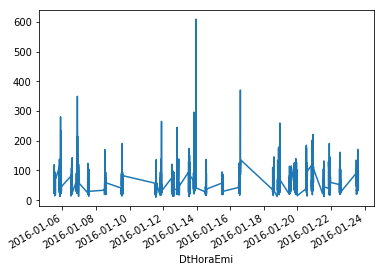

In [35]:
df_nf['ValorNota'].plot()
plt.show()

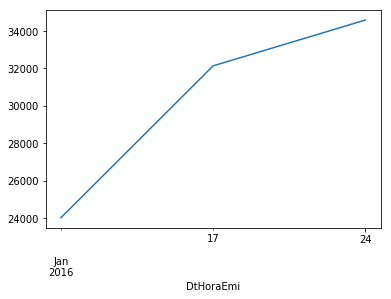

In [36]:
df_week.plot()
plt.show()